In [2]:
# Lasciate questa cella così ogni volta che aggiornate un file python, 
# anche gli import nel notebook vengono aggiornati

%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np

from Utils import *
from constants import *

from Environment import *
from Non_Stationary_Environment import *

from Social_influence import *
from Network import Network

from Simulation import *

from Ecommerce import *
from Ecommerce3 import *
from Ecommerce4 import *
from Ecommerce5 import *
from Ecommerce6 import *

## Step 2

In [3]:
simulate_step2()

optimal allocation is: [60. 60. 20. 60.  0.] with a reward of: 457
estimated_opt_allocation is: [60. 60. 20. 60.  0.] with a reward of: 457


## Step 3

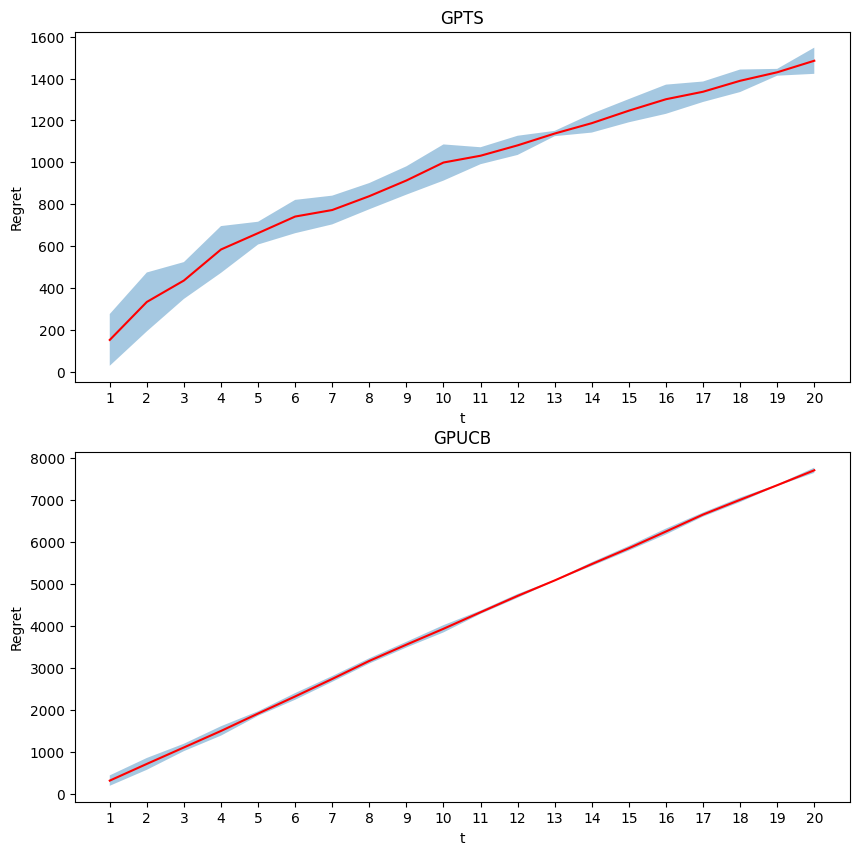

In [6]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step3()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 4

In [11]:
gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts = simulate_step4()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 5

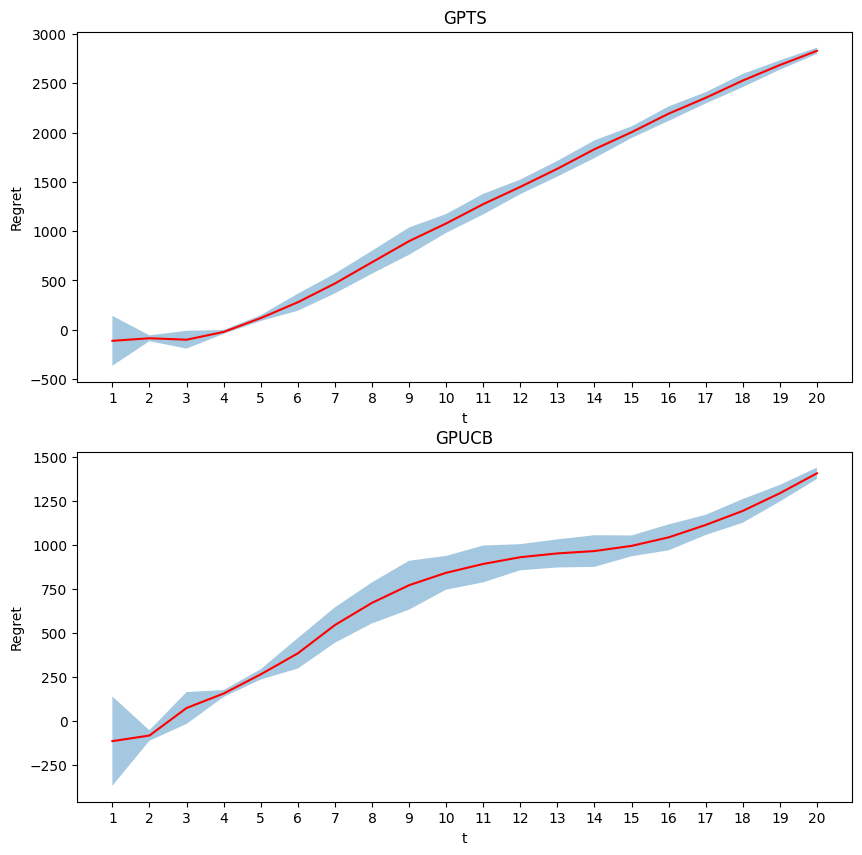

In [4]:
gpucb_rewards_per_experiment, gpts_rewards_per_experiment, opts = simulate_step5()
plot_regrets(gpts_rewards_per_experiment, gpucb_rewards_per_experiment, opts, ["GPTS", "GPUCB"])

## Step 6

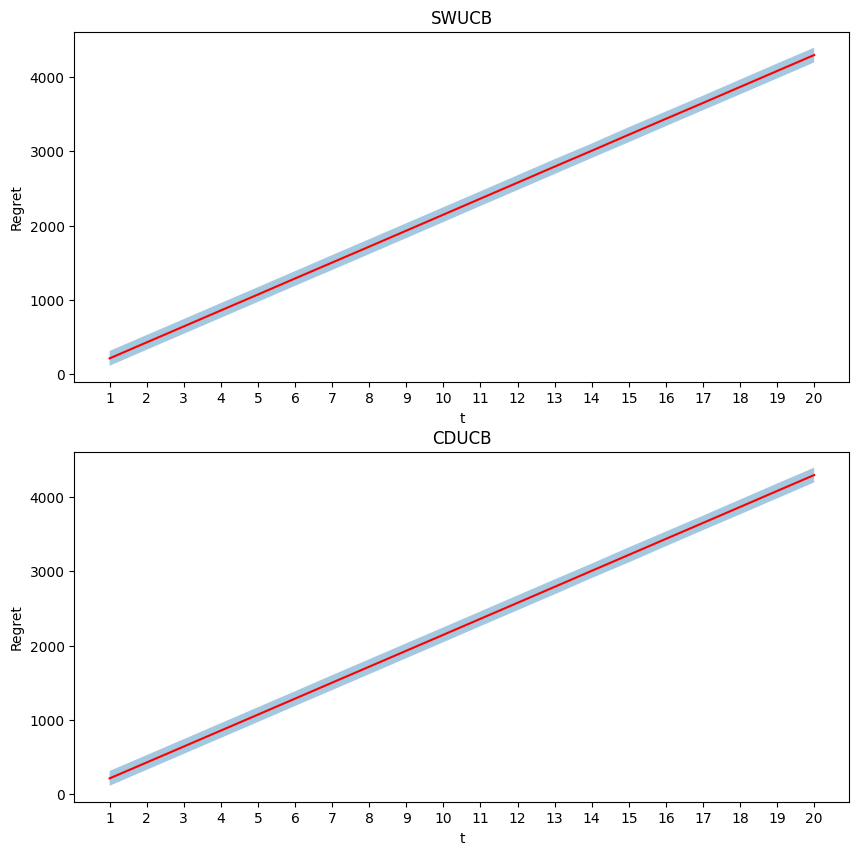

In [8]:
swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts = simulate_step6()
plot_regrets(swucb_rewards_per_experiment, cducb_rewards_per_experiment, opts, ["SWUCB", "CDUCB"])